In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**STEPS**
* Problem Definition
* Exploration
* Data Preprocessing
* Modelling 
* Evaluation

# Problem Definition
* ML model which predicts passengers who survived the titanic sinking.
* algorithm : K-nearest neighbors algorithm used for modelling
* Output (Predictions) : Survived (0 for deceased and 1 for survived)

# Exploration

In [2]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Reading the files
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')

In [4]:
# test data info
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# train data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Cabin to be dropped as more than half are null.
* Age to be imputed using KNN imputer
* PassengerId , Name and Ticket canbe dropped
* Sex and Embarked are categorical which canbe encoded.

In [6]:
# Basic info of train data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


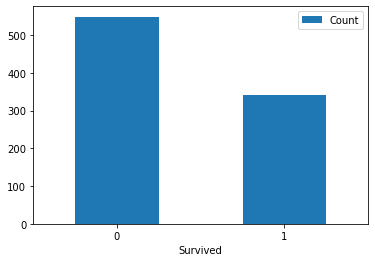

In [7]:
# Surviours plot
df = pd.DataFrame({'Survived':['0', '1'], 'Count':[len(train_data.loc[train_data['Survived'] == 0]),len(train_data.loc[train_data['Survived'] == 1])]})
ax = df.plot.bar(x='Survived', y='Count',rot=0)

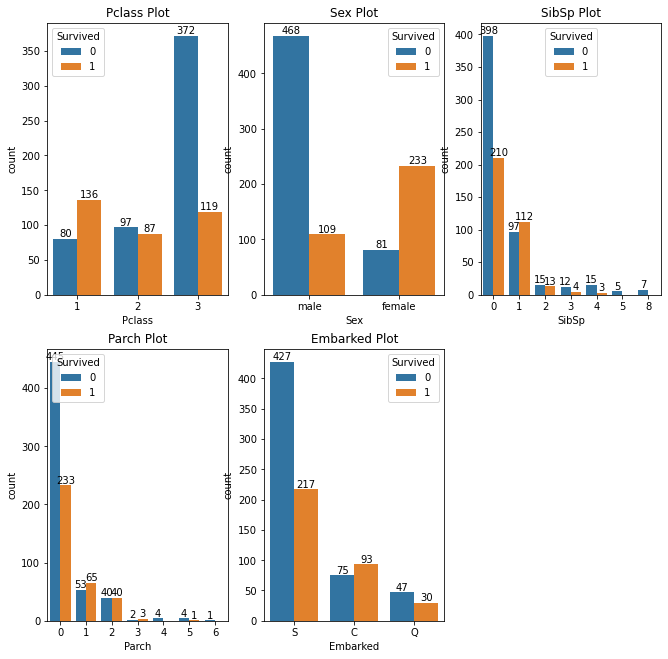

In [8]:
# plots of Survivals based on Features
plot_features = ['Pclass', 'Sex','SibSp', 'Parch','Embarked']

plt.figure(figsize=(11,11))
for i,col in enumerate(plot_features):
    plt.subplot(2,3,i+1)
    ax = sns.countplot(data=train_data,x = col,hue='Survived')
    for j in range(len(ax.containers)):
        ax.bar_label(ax.containers[j])
    plt.title(f'{col} Plot')

plt.show()

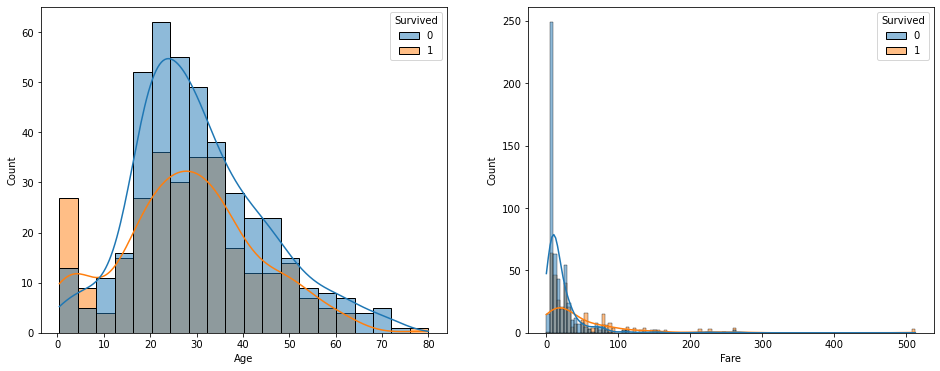

In [9]:
# plots of Survivals based on Features - Age , Fare
plt.figure(figsize = (16,6))

plt.subplot(121)
sns.histplot(data=train_data,x='Age',hue='Survived',kde=True)
plt.subplot(122)
sns.histplot(data=train_data,x='Fare',hue='Survived',kde=True)

plt.show()

**Feature Classification**
* Pclass, Age, Sibsp, Parch, Fare - Numeric features
* Embarked, Sex                   - Categorical features

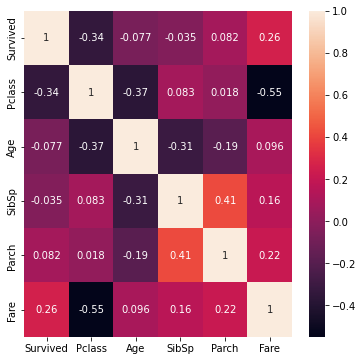

In [10]:
# Corelation heatmap for numeric features

plt.figure(figsize=(6,6))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(),annot=True)
plt.show()

* Features Pclass,Age and SibSp have negative correlation with Survived.
* Features Parch and Fare have positive correlation.

# Data Preprocessing

**Feature Selection**

In [11]:
#Training set
X_train = train_data.drop(['Survived','PassengerId','Name','Cabin','Ticket'],axis=1)
y_train = train_data['Survived']

In [12]:
#Testing set
X_test = test_data.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)

**Encoding of Categorical features - Sex & Embarked**

In [13]:
from sklearn.preprocessing import OrdinalEncoder

X_train["Embarked"].fillna( method ='ffill', inplace = True)
encoder = OrdinalEncoder()
encoder_train = pd.DataFrame(encoder.fit_transform(X_train[['Sex','Embarked']]),columns=['Sex','Embarked'])
encoder_test = pd.DataFrame(encoder.transform(X_test[['Sex','Embarked']]),columns=['Sex','Embarked'])

X_train = pd.concat([X_train.drop(['Sex','Embarked'],axis=1),encoder_train],axis=1)
X_test = pd.concat([X_test.drop(['Sex','Embarked'],axis=1),encoder_test],axis=1)

**Imputation of Age feature**

In [14]:
from sklearn.impute import KNNImputer
features = [col for col in X_train.columns]

# using KNN Imputer with K=3
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=features)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns=features)

**Feature Scaling**

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = features)
X_test = pd.DataFrame(scaler.transform(X_test),columns = features)

**K-value Selection**
* Looping from 2 to Sqrt(N) , Where N is the total size of train_data.
* K-Value with least error is selected.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
error_rate=[]#list that will store the average error rate value of k
k_values=[]
for i in range (2,int(np.sqrt(len(X_train)))):  #Took the range of k from 2 to Sqrt(len(train_data))
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    predict_i=clf.predict(X_train)
    error_rate.append(np.mean(predict_i!=y_train))
    k_values.append(i)
error_rate

[0.12457912457912458,
 0.11784511784511785,
 0.13468013468013468,
 0.13019079685746351,
 0.15600448933782268,
 0.15600448933782268,
 0.14590347923681257,
 0.15712682379349047,
 0.16947250280583614,
 0.16947250280583614,
 0.16947250280583614,
 0.1717171717171717,
 0.1638608305274972,
 0.16722783389450055,
 0.16947250280583614,
 0.17059483726150393,
 0.1750841750841751,
 0.1739618406285073,
 0.17620650953984288,
 0.1739618406285073,
 0.17732884399551066,
 0.17620650953984288,
 0.18069584736251404,
 0.17732884399551066,
 0.17957351290684623,
 0.17845117845117844,
 0.1750841750841751]

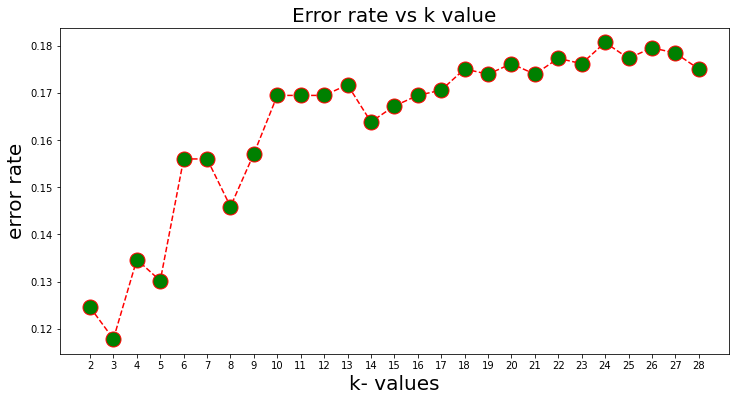

In [17]:
#plotting the error rate vs k graph 
k_end = int(np.sqrt(len(X_train)))
plt.figure(figsize=(12,6))
plt.plot(range(2,k_end),error_rate,marker="o",markerfacecolor="green",
         linestyle="dashed",color="red",markersize=15)
plt.title("Error rate vs k value",fontsize=20)
plt.xlabel("k- values",fontsize=20)
plt.ylabel("error rate",fontsize=20)
plt.xticks(range(2,k_end))
plt.show()

In [18]:
# K-value
k = k_values[np.argmin(error_rate)]

# Modelling

In [19]:
# Model definition
# Setting nearest neighbours size to 3
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=k)

In [20]:
#Fitting on final model
neigh.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
#predictions on train and test
y_pred_train = neigh.predict(X_train)
y_pred_test = pd.DataFrame(neigh.predict(X_test),columns=['Survived'])

# Evaluation

In [22]:
# Classification Report on train data set
from sklearn.metrics import classification_report
print('Classification Report on Train Data','\n\n',classification_report(y_train,y_pred_train))

Classification Report on Train Data 

               precision    recall  f1-score   support

           0       0.89      0.93      0.91       549
           1       0.88      0.81      0.84       342

    accuracy                           0.88       891
   macro avg       0.88      0.87      0.87       891
weighted avg       0.88      0.88      0.88       891



In [23]:
# Submissions
submissions = pd.concat([test_data.PassengerId,y_pred_test],axis=1)
submissions.to_csv('submission.csv',index=False)